
# Decomposing the impact of a shock 

When working with a model it is often useful to have a better sense of the contribution of different channels to a final result.  For example, an increase in interest rates will tend to reduce investment and consumer demand -- contributing to a reduction in GDP. At the same time, lower inflation as the higher interest rate takes effect will tend to work in the opposite direction. 

The `tracedep()` and `tracepre()` methods introduced in the previous section give a sense of impacts, but the `modelflow` methods `,dekomp()` and `.attributon` take that one step further by calculting the precise contribution of each channel to the overall result.



## Prepare the workspace

As always before running `modelflow` the python environment needs to be initialized and libraries to be used imported.

In [18]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

# Modules from Modelflow 
from modelclass import model 

# optional functionalities 
model.widescreen()
model.scroll_off()

# Output compatabiltity with LaTeX 
latex=False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the pre-existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions.

The following three lines:

 1. Load the model and simulates it to establish a baseline.
 2. Creates a copy of the baseline dataframe, changing the carbon tax rate  to 29 USD/Ton for emissions from each of oil, coal and natural gas.
 3. Runs a simulation, using these revised carbon tax rates and stores the the result dataframe.
  

In [19]:
mpak,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')
alternative  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")
result = mpak(alternative,2020,2100,keep='Carbon tax nominal 30') # simulates the model 

file read:  C:\mflow\modelflow-manual\papers\mfbook\content\models\pak.pcim



## The mathematics of attribution

At its root the idea of attribution is simply taking the total derivative of the model to identify the sensitivity of the equation we are interested in to changes elsewhere in the model and then combine that with the changes in other variables. 

Take a variable y that is a function of two other variables a and b.  In the model the relationship might be written as:


$y = f(a,b)$

If there are two observations 

\begin{eqnarray}
y_0 = f(a_0,b_0)\\
y_1 = f(a_1,b_1)
\end{eqnarray}

then we also have the change in all three variables $\Delta y, \Delta a, \Delta b$ and the total derivative of y can be written as:


$\Delta y = \underbrace{\Delta a \dfrac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \dfrac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

The first expresion can be called $\Omega_a$ or the contribution of changes in a to changes in y, and the second $\Omega_b$,  or the contribution of changes in b to changes in y.  


The `modelflow` method ` .totdif()` performs a numerical approximation of $\Omega_a$ and $\Omega_b$ by performing two runs of the model:

\begin{eqnarray}  
y_0&=&f(a_{0},b_{0}) \\
y_1&=&f(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

and calculates $\Omega_a$ and $\Omega_b$ as:

\begin{eqnarray}  
\Omega_a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega_b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



And: 

\begin{eqnarray}
residual = \Omega_a + \Omega_b -(y_1 - y_0) 
\end{eqnarray}

If the model is fairly linear, the residual will be small. 



## Model attribution or  single equation attribution?

Above the relationship between y, a, and b was summarized by the function f(). 

$f(a,b)$ could represent a single equation in the model or it could represent the entire model. In the first instance, $\Delta a$ and $\Delta b$ would be treated as exogenous variables in the attribution calculation.  In the second instance, they would be all of the endogenous and exoegnous variables that directly and indirectly impact y.

Assume the simple equation example such that  $a$ and $b$ are simple variables. When $\Delta y$, $\Delta a$ and $\Delta b$ reflect the difference across scenarios (say the value of the three variables in `.lastdf` less the value in `.basedf` then;

$\Omega_a$, $\Omega_b$ are the absolute contribution of a and b to the change in y, and 
$100*\bigg[\cfrac{\Omega_a}{\Delta y}\bigg]$  $100*\bigg[\cfrac{\Omega_b}{\Delta y}\bigg]$ are the share of the change in y explained by a and b respectively.

If $\Delta y$, $\Delta a$ and $\Delta b$ are the changes over time ($\Delta y_t=y_t-y_{t-1}$), then $\Omega_a$, $\Omega_b$ are the contributions of a and b to the rate of growth of y, while $100*\bigg[\cfrac{\Omega_a}{\Delta y_{t-1}}\bigg]$  $100*\bigg[\cfrac{\Omega_b}{\Delta y_{t-1}}\bigg]$ are are the contributions of a and b to the rate of growth of y.







## Decomposing the changes in a single endogenous variable - formula attribution

The `modelflow` method `.dekomp()` is used to calculate the contribution of different RHS variables to the change in an endogenous variable.  

This method takes advantage of the fact that the model object stores the initial and most recent simulation result in two dataframes called `.basedf` and `.lastdf`, as well as all of the equations of the model. 

### The output of the `dekomp()` method

The `dekomp()` method calculates the contribution to changes in the level of the dependent variables in a given equation. It does not calculate the contributions of variables that determine the changes observed in the RHS variables themselves.

In the example below the contribution to the change in Total emissions is decomposed into the contribution from each of three sources in the model, the consumption of Crude Oil, Natural Gas and Coal.  As the equation for total emissions is just the sum of the three this is a fairly trivial decomposition, but it provides an easily understood illustration of the process at work.

The results of the `.dekomp` command are divided into 4 separate tables.

1. The first table of output shows the changes that are to be explained. **The changes are always calculated by comparing the results from the most solution (`.lastdf`) with the data from the baseline (`.basedf`)** of the model object.
2. The second table shows the changes between the contributions of the LHS variables to the changes in the RHS variable.  Because this equation is an additive identity, these amount to the changes in each of the variables themselves. 
3. the third table expresses these changes as a share of the total change.
4. The last shows the contributions of these changes to the change in the growth rate of the dependent variable (these results would need to be multiplied by 100 to see that they add to the totals in table 1.

In this instance we want to udnerstand teh contribution of each of the sources of emissions to the change in the total.  The `.frml` method reports the equation, which in this case is just the sum of the three carbon producing energy sources, coal oil and natural gas.

In [20]:
mpak['PAKCCEMISCO2TKN'].frml

PAKCCEMISCO2TKN : FRML <IDENT> PAKCCEMISCO2TKN = PAKCCEMISCO2CKN+PAKCCEMISCO2OKN+PAKCCEMISCO2GKN $



The results of the `.dekomp` command are divided into 4 separate tables.

1. The first table of output shows the changes that are to be explained/ **The changes are always drawn from the most solution, i.e. from the `.basedf` and `.lastdf` DataFrames** of the model object.
2. The second table shows the changes between the contributions of the LHS variables to the changes in the RHS variable.  Because this equation is an additive identity, these amount to the changes in each of the variables themselves. 
3. the third table expresses these changes as a share of the total change.
4. The last shows the contributions of these changes to the change in the growth rate of the dependent variable (these results would need to be multiplied by 100 to see that they add to the totals in table 1.

In [21]:
with mpak.set_smpl(2020,2025):
    mpak['PAKCCEMISCO2TKN'].dekomp()


Formula        : FRML <IDENT> PAKCCEMISCO2TKN = PAKCCEMISCO2CKN+PAKCCEMISCO2OKN+PAKCCEMISCO2GKN $ 

                        2020         2021         2022         2023         2024         2025
Variable    lag                                                                              
Base        0   213515545.24 217548186.56 221072469.97 225253519.79 230370294.27 236240658.85
Alternative 0   153790043.82 158136496.56 162262040.05 167116569.38 173010036.73 179772129.03
Difference  0   -59725501.42 -59411690.00 -58810429.92 -58136950.40 -57360257.55 -56468529.82
Percent     0         -27.97       -27.31       -26.60       -25.81       -24.90       -23.90

 Contributions to differende for  PAKCCEMISCO2TKN
                            2020         2021         2022         2023         2024         2025
Variable        lag                                                                              
PAKCCEMISCO2CKN 0   -24185661.58 -24251583.97 -24147394.08 -23999340.06 -23829476.98 -23

The following single-equation decomposition looks to the impact on inflation.  The inflation equation is more complex and has more direct causal variables, so here the decomposition is more helpful.

Recall the inflation equation is given by the `.frml` method for its normalized version and `.eviews` for its original specification.  The equation for the consumer price level (PAKNECONPRVTXN) was originally specified in eviews as:

In [22]:
mpak['PAKNECONPRVTXN'].eviews

PAKNECONPRVTXN : @IDENTITY PAKNECONPRVTXN  = ((PAKNECONENGYSH^PAKCESENGYCON)  * PAKNECONENGYXN^(1  - PAKCESENGYCON)  + (PAKNECONOTHRSH^PAKCESENGYCON)  * PAKNECONOTHRXN^(1  - PAKCESENGYCON))^(1  / (1  - PAKCESENGYCON))


When normalized the equation solves for the **level** of the price deflator.  It is this normalized equation that is:

In [23]:
mpak['PAKNECONPRVTXN'].frml

PAKNECONPRVTXN : FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $


Because the normalized equation solves for the level of the price deflator, te decomposition will show the contributions of each explanatory variable to the increase in the price level (not that of the inflation rate).

Note in the Pakistan model, consumer inflation is derived as a CET aggregation of the price of energy goods(PAKNECONENGYXN) and non-energy goods (PAKNECONOTHRXN).

In [24]:
with mpak.set_smpl(2020,2025):
    mpak['PAKNECONPRVTXN'].dekomp()


Formula        : FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $ 

                      2020       2021       2022       2023       2024       2025
Variable    lag                                                                  
Base        0         1.67       1.82       1.98       2.14       2.30       2.45
Alternative 0         1.72       1.89       2.07       2.23       2.39       2.55
Difference  0         0.06       0.07       0.08       0.09       0.10       0.10
Percent     0         3.40       3.84       4.11       4.21       4.18       4.06

 Contributions to differende for  PAKNECONPRVTXN
                         2020       2021       2022       2023       2024       2025
Variable       lag                                                                  
PAKNECONENGYSH 0        -0.00      -0.00      -0.00      -0.00      -0.00      

Interestingly only 25% of the increase in the price level each period is due to the direct channel (the impact on energy prices), the bulk of the increase comes indirectly through other prices.  Indeed as time progresses this share rises from 77% in the first year of the price change (2020) to 86% by 2024.

Below is the formula for nonenergy consumer prices and its decomposition. This equation is written out as a more standard inflation equation reflecting changes in the cost of local goods production (PAKNYGDPFCSTXN), Government taxes on goods and services (PAKGGREVGNFSXN), the price of imports (PAKNEIMPGNGSXN) and the influence of the economic cycle (PAKNYGDPGAP_).

In [25]:
mpak['PAKNECONOTHRXN'].eviews

PAKNECONOTHRXN : DLOG(PAKNECONOTHRXN) = 0.590372627657176*DLOG(PAKNYGDPFCSTXN) + D(PAKGGREVGNFSXN/100) + (1 - 0.590372627657176)*DLOG(PAKNEIMPGNFSXN) + 0.2*PAKNYGDPGAP_/100


In [26]:
with mpak.set_smpl(2020,2025):
    mpak['PAKNECONOTHRXN'].dekomp()


Formula        : FRML <DAMP,STOC> PAKNECONOTHRXN = (PAKNECONOTHRXN(-1)*EXP(PAKNECONOTHRXN_A+ (0.590372627657176*((LOG(PAKNYGDPFCSTXN))-(LOG(PAKNYGDPFCSTXN(-1))))+((PAKGGREVGNFSXN/100)-(PAKGGREVGNFSXN(-1)/100))+(1-0.590372627657176)*((LOG(PAKNEIMPGNFSXN))-(LOG(PAKNEIMPGNFSXN(-1))))+0.2*PAKNYGDPGAP_/100) )) * (1-PAKNECONOTHRXN_D)+ PAKNECONOTHRXN_X*PAKNECONOTHRXN_D  $ 

                      2020       2021       2022       2023       2024       2025
Variable    lag                                                                  
Base        0         1.70       1.86       2.02       2.18       2.34       2.50
Alternative 0         1.74       1.92       2.09       2.26       2.43       2.59
Difference  0         0.05       0.06       0.07       0.08       0.09       0.09
Percent     0         2.68       3.18       3.50       3.65       3.67       3.58

 Contributions to differende for  PAKNECONOTHRXN
                           2020       2021       2022       2023       2024       2025


These results indicate that much of the initial impact on prices is coming the increase in the price of imported goods (which includes a large fuel component). As time progresses, the imported inflation component declines and the lagged consumption price dominates.  Other factors such as the cost of domestically produced goods play a larger role and the net impact of imported prices (the total of the contemporaneous and lagged value) approaches zero. Cyclical pressure are initially adding to inflation before declining and eventually turning negative.  

In [27]:
mpak['PAKNECONOTHRXN'].dif.df

,PAKNECONOTHRXN
2020,0.045473
2021,0.059084
2022,0.070827
2023,0.079797
2024,0.085849
...,...
2096,0.430279
2097,0.449908
2098,0.470503
2099,0.492105


The dekomp method with option pct=False shows the change in the level of the LHS variable and returns three data frames.

The first (named control below) shows the pre-shock and post shock levels of the dependent variable and their differences.
The second (named delta below) shows the change in the  levels of the dependent variable and their differences.The second (named delta below) shows the change in the third (named contributions below) shows the contribution of each RHS variable to the change in the LHS variable (expressed as a percent of the total change). 


In [28]:
control,delta,contributions=mpak.dekomp('PAKNECONOTHRXN',lprint=False)
mpak.dekomp('PAKNECONOTHRXN',lprint=False)
control

,,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
Variable,lag,,,,,,,,,,,,,,,,,,,,,
Base,0,1.695682,1.857535,2.021492,2.183344,2.342145,2.49833,2.652585,2.8055,2.957674,3.109926,...,79.631396,84.163096,88.952875,94.015343,99.365938,105.020967,110.997662,117.31423,123.989906,131.045014
Alternative,0,1.741156,1.916618,2.092319,2.263141,2.427994,2.587665,2.743347,2.896118,3.046983,3.197087,...,79.976591,84.52369,89.329642,94.40909,99.777509,105.451246,111.447571,117.784732,124.48201,131.559775
Difference,0,0.045473,0.059084,0.070827,0.079797,0.085849,0.089335,0.090762,0.090618,0.089308,0.08716,...,0.345195,0.360594,0.376767,0.393747,0.411572,0.430279,0.449908,0.470503,0.492105,0.514761
Percent,0,2.681694,3.180755,3.503693,3.654781,3.665399,3.575779,3.421632,3.230024,3.019539,2.802648,...,0.433491,0.428447,0.423558,0.418811,0.414198,0.409707,0.405331,0.401062,0.396891,0.392812


The second dataframe shows the changes in the various RHS variables, several of which occur with bot current and lagged values. In this case of the price variables, this is because they enter the original equation as inflation rates (the change in levels over time).

In [29]:
delta

2020      2021      2022      2023      2024  \
Variable         lag                                                     
PAKNECONOTHRXN   -1       -0.0  0.050056    0.0645  0.076609  0.085609   
PAKNECONOTHRXN_A  0       -0.0      -0.0      -0.0      -0.0      -0.0   
PAKNYGDPFCSTXN    0   0.000836  0.007718  0.013719  0.018645  0.022346   
                 -1       -0.0 -0.000921  -0.00846 -0.014937  -0.02017   
PAKGGREVGNFSXN    0       -0.0      -0.0      -0.0      -0.0      -0.0   
                 -1       -0.0      -0.0      -0.0      -0.0      -0.0   
PAKNEIMPGNFSXN    0   0.041706  0.044573  0.046861  0.048517  0.049572   
                 -1       -0.0 -0.047035 -0.049818 -0.051848 -0.053191   
PAKNYGDPGAP_      0   0.003025  0.003844  0.003054  0.001685  0.000417   
PAKNECONOTHRXN_D  0       -0.0      -0.0      -0.0      -0.0      -0.0   
PAKNECONOTHRXN_X  0       -0.0      -0.0      -0.0      -0.0      -0.0   

                          2025      2026      2027      2028      2029  ...  \
Variable         lag                                                    ...   
PAKNECONOTHRXN   -1   0.091495   0.09471  0.095816  0.095339  0.093708  ...   
PAKNECONOTHRXN_A  0       -0.0      -0.0      -0.0      -0.0      -0.0  ...   
PAKNYGDPFCSTXN    0   0.024928  0.026565  0.027434  0.027685  0.027443  ...   
                 -1  -0.024037 -0.026685 -0.028318 -0.029139 -0.029315  ...   
PAKGGREVGNFSXN    0       -0.0      -0.0      -0.0      -0.0      -0.0  ...   
                 -1       -0.0      -0.0      -0.0      -0.0      -0.0  ...   
PAKNEIMPGNFSXN    0   0.050134  0.050306  0.050177  0.049814  0.049272  ...   
                 -1  -0.053934   -0.0542   -0.0541 -0.053722 -0.053137  ...   
PAKNYGDPGAP_      0  -0.000607 -0.001326 -0.001771 -0.002003 -0.002074  ...   
PAKNECONOTHRXN_D  0       -0.0      -0.0      -0.0      -0.0      -0.0  ...   
PAKNECONOTHRXN_X  0       -0.0      -0.0      -0.0      -0.0      -0.0  ...   

                          2091      2092      2093      2094      2095  \
Variable         lag                                                     
PAKNECONOTHRXN   -1   0.349325  0.364821  0.381098   0.39819  0.416137   
PAKNECONOTHRXN_A  0       -0.0      -0.0      -0.0      -0.0      -0.0   
PAKNYGDPFCSTXN    0   0.158246  0.165899  0.173935  0.182372  0.191226   
                 -1  -0.159859 -0.167574 -0.175677 -0.184184 -0.193115   
PAKGGREVGNFSXN    0       -0.0      -0.0      -0.0      -0.0      -0.0   
                 -1       -0.0      -0.0      -0.0      -0.0      -0.0   
PAKNEIMPGNFSXN    0   0.042454  0.042892  0.043358  0.043851  0.044373   
                 -1  -0.044456 -0.044891 -0.045354 -0.045846 -0.046366   
PAKNYGDPGAP_      0  -0.000874 -0.000923 -0.000976 -0.001032 -0.001093   
PAKNECONOTHRXN_D  0       -0.0      -0.0      -0.0      -0.0      -0.0   
PAKNECONOTHRXN_X  0       -0.0      -0.0      -0.0      -0.0      -0.0   

                          2096      2097      2098      2099      2100  
Variable         lag                                                    
PAKNECONOTHRXN   -1   0.434975  0.454746  0.475491  0.497255  0.520085  
PAKNECONOTHRXN_A  0       -0.0      -0.0      -0.0      -0.0      -0.0  
PAKNYGDPFCSTXN    0   0.200518  0.210266  0.220492  0.231218  0.242465  
                 -1  -0.202488 -0.212323 -0.222642 -0.233466 -0.244819  
PAKGGREVGNFSXN    0       -0.0      -0.0      -0.0      -0.0      -0.0  
                 -1       -0.0      -0.0      -0.0      -0.0      -0.0  
PAKNEIMPGNFSXN    0   0.044925  0.045507  0.046122  0.046769   0.04745  
                 -1  -0.046917   -0.0475 -0.048115 -0.048763 -0.049447  
PAKNYGDPGAP_      0  -0.001158 -0.001227 -0.001301  -0.00138 -0.001464  
PAKNECONOTHRXN_D  0       -0.0      -0.0      -0.0      -0.0      -0.0  
PAKNECONOTHRXN_X  0       -0.0      -0.0      -0.0      -0.0      -0.0  

[11 rows x 81 columns]

The final dataframe is the omegas for each variable.  For the variables that appear as growth rates the Omegas would have to be added together to get a sense of the contribution of the variable.

In [30]:
contributions # as a percent of the total change (the omegas)

2020          2021          2022          2023  \
Variable         lag                                                         
PAKNECONOTHRXN   -1    -0.000002  8.471979e+01  9.106708e+01  9.600599e+01   
PAKNYGDPFCSTXN    0     1.838673  1.306273e+01  1.936999e+01  2.336622e+01   
PAKNEIMPGNFSXN    0    91.715310  7.544053e+01  6.616287e+01  6.080062e+01   
PAKNECONOTHRXN_A  0    -0.000002 -8.291718e-07 -3.826416e-07 -8.563268e-07   
PAKGGREVGNFSXN    0    -0.000002 -8.291718e-07 -3.826416e-07 -8.563268e-07   
                 -1    -0.000002 -8.291718e-07 -3.826416e-07 -8.563268e-07   
PAKNECONOTHRXN_D  0    -0.000002 -8.291718e-07 -3.826416e-07 -8.563268e-07   
PAKNECONOTHRXN_X  0    -0.000002 -8.291718e-07 -3.826416e-07 -8.563268e-07   
PAKNYGDPGAP_      0     6.652521  6.505646e+00  4.312319e+00  2.111404e+00   
PAKNEIMPGNFSXN   -1    -0.000002 -7.960786e+01 -7.033726e+01 -6.497557e+01   
PAKNYGDPFCSTXN   -1    -0.000002 -1.558470e+00 -1.194394e+01 -1.871909e+01   
Total             0   100.206488  9.856235e+01  9.863106e+01  9.858957e+01   
Residual          0     0.206488 -1.437645e+00 -1.368944e+00 -1.410430e+00   

                              2024        2025        2026        2027  \
Variable         lag                                                     
PAKNECONOTHRXN   -1   9.972053e+01  102.417696  104.349539  105.735835   
PAKNYGDPFCSTXN    0   2.602969e+01   27.903697   29.268441   30.274118   
PAKNEIMPGNFSXN    0   5.774378e+01   56.119001   55.426860   55.371917   
PAKNECONOTHRXN_A  0  -8.409285e-07   -0.000002   -0.000003   -0.000003   
PAKGGREVGNFSXN    0  -8.409285e-07   -0.000002   -0.000003   -0.000003   
                 -1  -8.409285e-07   -0.000002   -0.000003   -0.000003   
PAKNECONOTHRXN_D  0  -8.409285e-07   -0.000002   -0.000003   -0.000003   
PAKNECONOTHRXN_X  0  -8.409285e-07   -0.000002   -0.000003   -0.000003   
PAKNYGDPGAP_      0   4.854981e-01   -0.679664   -1.461334   -1.954720   
PAKNEIMPGNFSXN   -1  -6.195897e+01  -60.372481  -59.716891  -59.700832   
PAKNYGDPFCSTXN   -1  -2.349448e+01  -26.906654  -29.400610  -31.249838   
Total             0   9.852605e+01   98.481584   98.465988   98.476464   
Residual          0  -1.473952e+00   -1.518416   -1.534012   -1.523536   

                            2028        2029  ...        2091        2092  \
Variable         lag                          ...                           
PAKNECONOTHRXN   -1   106.752651  107.511949  ...  101.196609  101.172119   
PAKNYGDPFCSTXN    0    30.999657   31.485337  ...   45.842373   46.007151   
PAKNEIMPGNFSXN    0    55.777450   56.530802  ...   12.298466   11.894917   
PAKNECONOTHRXN_A  0    -0.000003   -0.000004  ...   -0.000002   -0.000002   
PAKGGREVGNFSXN    0    -0.000003   -0.000004  ...   -0.000002   -0.000002   
                 -1    -0.000003   -0.000004  ...   -0.000002   -0.000002   
PAKNECONOTHRXN_D  0    -0.000003   -0.000004  ...   -0.000002   -0.000002   
PAKNECONOTHRXN_X  0    -0.000003   -0.000004  ...   -0.000002   -0.000002   
PAKNYGDPGAP_      0    -2.242644   -2.379894  ...   -0.253115   -0.255902   
PAKNEIMPGNFSXN   -1   -60.153192  -60.964110  ...  -12.878395  -12.449233   
PAKNYGDPFCSTXN   -1   -32.627501  -33.633946  ...  -46.309647  -46.471657   
Total             0    98.506405   98.550120  ...   99.896280   99.897383   
Residual          0    -1.493595   -1.449880  ...   -0.103720   -0.102617   

                            2093        2094        2095        2096  \
Variable         lag                                                   
PAKNECONOTHRXN   -1   101.149447  101.128509  101.109217  101.091476   
PAKNYGDPFCSTXN    0    46.165290   46.316981   46.462418   46.601791   
PAKNEIMPGNFSXN    0    11.507896   11.136895   10.781395   10.440871   
PAKNECONOTHRXN_A  0    -0.000002   -0.000002   -0.000002   -0.000002   
PAKGGREVGNFSXN    0    -0.000002   -0.000002   -0.000002   -0.000002   
                 -1    -0.000002   -0.000002   -0.000002   -0.000002   
PAKNECONOTHRXN

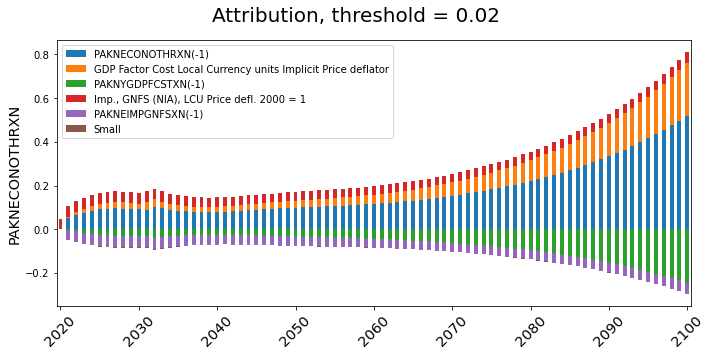

In [31]:
fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=False,rename=True,threshold=.02); #decomposition of the change in the level

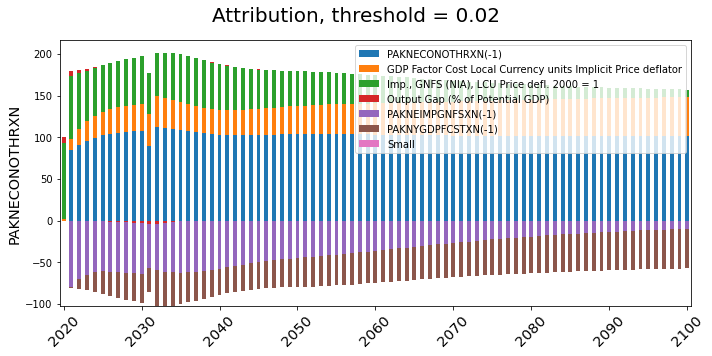

In [32]:
fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=True,rename=True,threshold=.02); # expressed as a share (the contributions share)

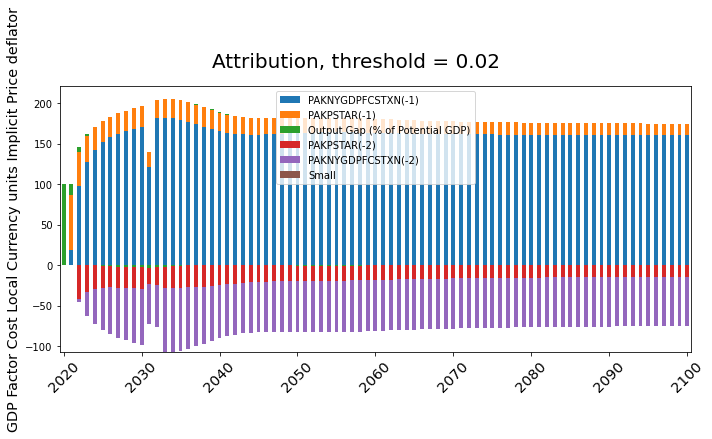

In [33]:
fig=mpak.dekomp_plot('PAKNYGDPFCSTXN',pct=True,rename=True,threshold=.02);

In [34]:
help(mpak.dekomp_plot)

Help on method dekomp_plot in module modelclass:

dekomp_plot(varnavn, sort=True, pct=True, per='', top=0.9, threshold=0.0, lag=True, rename=True, nametrans=<function Dekomp_Mixin.<lambda> at 0x0000018957CA8430>, time_att=False) method of modelclass.model instance
    Returns  a chart with attribution for a variable over the smpl  
    
    Parameters
    ----------
    varnavn : TYPE
        variable name.
    sort : TYPE, optional
        . The default is False.
    pct : TYPE, optional
        display pct contribution . The default is True.
    per : TYPE, optional
        DESCRIPTION. The default is ''.
    threshold : TYPE, optional
        cutoff. The default is 0.0.
    rename : TYPE, optional
        Use descriptions instead of variable names. The default is True.
    time_att : TYPE, optional
        Do time attribution . The default is False.
    lag : TYPE, optional
       separete by lags The default is True.           
    top : TYPE, optional
      where to place the titl

In [35]:
#mpak.dekomp_plot_per?
#mpak.dekomp_plot_per('PAKNECONPRVTXN',per=(2025,2030),threshold=0.2)  # gives a waterfall of contributions


## Impacts at the model level: the `.totdif()` method 

The method `.totdif()` returns an instance  the totdif class, which provides a number of methods and properties to explore decomposition at the model level.

It works by solving the model numerous time, each time changing one of the right hand side variables and calculating the impact on the dependent variable. By default it uses the values from the `.lastdf` Dataframe as the shock values and the values in `.basedf` as the initial values.

For the purpose of this exercise lets look at a simulation where monetary policy tightens raising the policy interest rate by 100 basis points for 3 years, and then look at the impact on inflation.

For advanced users the RHS variables can be grouped into user defined blocks, which helps identify causal chains.

To begin we reload the model.

In [36]:
mpak,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')
mpak.smpl(2016,2100)

file read:  C:\mflow\modelflow-manual\papers\mfbook\content\models\pak.pcim


Int64Index([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
            2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
            2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048,
            2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059,
            2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070,
            2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
            2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092,
            2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64')

To determine the mnemonic for the monetary policy, search the data dictionary for the word policy.

In [37]:
mpak['!*policy*'].des

PAKFMLBLPOLYXN        : Key Policy Interest Rate
PAKFMLBLPOLYXN_A      : Add factor:Key Policy Interest Rate
PAKFMLBLPOLYXN_D      : Fix dummy:Key Policy Interest Rate
PAKFMLBLPOLYXN_FITTED : Fitted  value:Key Policy Interest Rate
PAKFMLBLPOLYXN_X      : Fix value:Key Policy Interest Rate
PAKINTRDDIFF          : Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_A        : Add factor:Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_D        : Fix dummy:Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_FITTED   : Fitted  value:Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_X        : Fix value:Domestic Interest Rate Spread Over Policy Rate
PAKINTREDIFF          : External Interest Rate Spread Over Policy Rate
PAKINTREDIFF_A        : Add factor:External Interest Rate Spread Over Policy Rate
PAKINTREDIFF_D        : Fix dummy:External Interest Rate Spread Over Policy Rate
PAKINTREDIFF_FITTED   : Fitted  value:External Interest Rate Spread Over Pol

The policy variable is `PAKFMLBLPOLYXN`, do a quick visualization to see its level (percentage points or perhaps ppt / 100?).

In [38]:
mpak['PAKFMLBLPOLYXN'].df

,PAKFMLBLPOLYXN
2016,5.734297
2017,5.754622
2018,5.805750
2019,6.187512
2020,6.670351
...,...
2096,9.673475
2097,9.678917
2098,9.683851
2099,9.688309


Check to see if this is an endogenous variable or not:

In [39]:
#check to see if a variable is endogenous or endogenous
'PAKFMLBLPOLYXN' in mpak.endogene


True

It is endogenous so we will want in this case to exogenize the variable.

In [40]:
mpak['PAKFMLBLPOLYXN'].frml

PAKFMLBLPOLYXN : FRML <DAMP,STOC> PAKFMLBLPOLYXN = (100*PAKFMLBLPOLYXN_A+100* (0.900155952396245*PAKFMLBLPOLYXN(-1)/100+(1-0.900155952396245)*(PAKMPPOLNATRXN/100+1.2*(((LOG(PAKNECONPRVTXN))-(LOG(PAKNECONPRVTXN(-1))))-PAKINFLEXPT/100)+0.5*PAKNYGDPGAP_/100)) ) * (1-PAKFMLBLPOLYXN_D)+ PAKFMLBLPOLYXN_X*PAKFMLBLPOLYXN_D $


In [41]:
#newbase=baseline.c
newbase=mpak.fix(baseline,'PAKFMLBLPOLYXN')

#MUST create a new baseline with the variables fixed
newbase = mpak(newbase,2016,2100,keep='Baseline') # simulates the model 
mpak.basedf=newbase # need to reset the baseline which is used for comparisons



The folowing variables are fixed
PAKFMLBLPOLYXN


In [42]:
newbase.loc[2020:2030,'PAKFMLBLPOLYXN_D']


2020    1.0
2021    1.0
2022    1.0
2023    1.0
2024    1.0
2025    1.0
2026    1.0
2027    1.0
2028    1.0
2029    1.0
2030    1.0
Name: PAKFMLBLPOLYXN_D, dtype: float64

Create a new dataframe for the shocks scenario and increase the Policy rate by 1 percentage point during the period 2025-2027. In this scenario the monetary policy variable has been exogenized for the whole simulation period.



In [43]:

import modelmf  # needed to add the mfcalc functionality to pandas DatFarames

MPShock=newbase.upd('<2025 2027> PAKFMLBLPOLYXN_X + 1')
MPShock.loc[2023:2030,'PAKFMLBLPOLYXN_X']


2023    7.376232
2024    7.362666
2025    8.285334
2026    8.171706
2027    8.039316
2028    6.899970
2029    6.763110
2030    6.637192
Name: PAKFMLBLPOLYXN_X, dtype: float64

Now the model is simulated passing it as the input dataframe MPShock.
Once it has run, the results for a range of variables are displayed as percent deviation from baseline.

C:\Users\wb268970\.conda\envs\modelflow\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


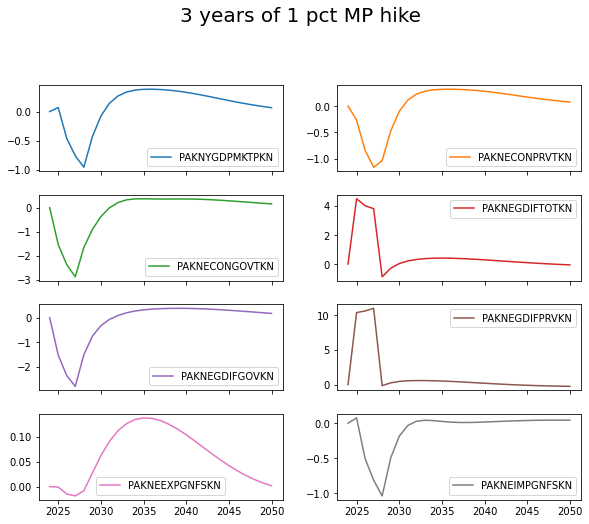

In [45]:
MPres = mpak(MPShock,2016,2100,keep='Increase Policy rate 1 ppt 2025-27') # simulates the model
with mpak.set_smpl(2024,2050):
    fig=mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEGDIFGOVKN PAKNEGDIFPRVKN PAKNEEXPGNFSKN PAKNEIMPGNFSKN'].difpctlevel.mul100.plot(title="3 years of 1 pct MP hike")


These results suggest an anomolous reaction of private investment to the increase in the interest rates (an increase in investment rather than a decline).  An inspection of the equation for private investment reveals that contrary to economic logic, private investment is estimated to increase in response to a hike in the cost of capital -- there is a positive coefficient to the growth of the cost of capital in the below readout of the real private investment equation: `PAKNEKRTTOTLCN`.

In [51]:
mpak['PAKNEGDIFPRVKN'].eviews


PAKNEGDIFPRVKN : (PAKNEGDIFPRVKN/PAKNEGDIKSTKKN( - 1)) = 0.00212272413966296 + 0.970234989019907*(PAKNEGDIFPRVKN( - 1)/PAKNEGDIKSTKKN( - 2)) + (1 - 0.970234989019907)*(DLOG(PAKNYGDPPOTLKN) + PAKDEPR) + 0.0525240494260597*DLOG(PAKNEKRTTOTLCN/PAKNYGDPFCSTXN)


# Revise model to correct problem with private investment

Below we revise the equation so that investment declines when the cost of capital rises. 

```
DLOG(PAKNEGDIFPRVKN) = -0.131378303837-0.141169219888*(LOG(PAKNEGDIFPRVKN(-1))-LOG(0.3*(PAKNYGDPPOTLKN(-1)/(PAKNEKRTTOTLCN(-1)))*(PAKDEPR(-1)+DLOG(PAKLMEMPSTRLCN(-1))+DLOG(PAKNYGDPTFP(-1))/0.3)))+1*DLOG(PAKNYGDPMKTPKN)-0.05*DLOG(PAKNEKRTTOTLCN/PAKNEGDIFPRVXN)
```


In [52]:
#mpak1,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep="Baseline")
mpakNEW,baselinereal = mpak.equpdate('''
  <DAMP,STOC> PAKNEGDIFPRVKN = EXP(LOG(PAKNEGDIFPRVKN(-1))-0.131378303837-0.141169219888*(LOG(PAKNEGDIFPRVKN(-1))-LOG(0.3*(PAKNYGDPPOTLKN(-1)/(PAKNEKRTTOTLCN(-1)))*(PAKDEPR(-1)+DLOG(PAKLMEMPSTRLCN(-1))+DLOG(PAKNYGDPTFP(-1))/0.3)))+1*DLOG(PAKNYGDPMKTPKN)-0.05*DLOG(PAKNEKRTTOTLCN/PAKNEGDIFPRVXN))
''',add_add_factor=True, calc_add=True,newname='Revised ')

AttributeError: 'Normalized_frml' object has no attribute 'endovar'

In [77]:
with mpak.set_smpl(2024,2040):
    print(mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEEXPGNFSKN PAKNEIMPGNFSKN PAKFMLBLPOLYXN'].difpctlevel.mul100.df)
    
    
#mpak['PAKNECONPRVTKN'].difpctlevel.df
#mpak['PAKNECONPRVTKN'].difpctlevel.df

      PAKNYGDPMKTPKN  PAKNECONPRVTKN  PAKNECONGOVTKN  PAKNEGDIFTOTKN  \
2024    2.254220e-07    1.613720e-07    5.823880e-07        0.000001   
2025    3.745243e-07    2.938799e-07    9.067130e-07        0.000002   
2026    4.586167e-07    3.564450e-07    1.134333e-06        0.000002   
2027    4.987732e-07    3.725283e-07    1.287033e-06        0.000003   
2028    4.627886e-07    3.148205e-07    1.316371e-06        0.000003   
2029    4.330686e-07    2.653726e-07    1.350662e-06        0.000003   
2030    4.297807e-07    2.438668e-07    1.433047e-06        0.000004   
2031   -3.631098e-01   -9.033275e-02    1.878607e-01       -1.406770   
2032   -2.659031e-01   -1.417627e-02    2.462569e-01       -1.306756   
2033   -1.859509e-01    4.177231e-02    2.769705e-01       -1.187282   
2034   -1.235821e-01    7.882108e-02    2.864809e-01       -1.060803   
2035   -7.837496e-02    9.886055e-02    2.786631e-01       -0.937009   
2036   -4.906216e-02    1.043594e-01    2.563387e-01       -0.82

In [58]:
junk=mpak.exodif()

junk.loc[2023:2035,:]
    

,PAKPANUSATLS_X,WLDFCRUDE_PETRO
2023,106.693704,0.0
2024,106.566459,0.0
2025,106.454266,30.0
2026,106.353322,30.0
2027,106.261138,30.0
2028,106.175825,0.0
2029,106.095356,0.0
2030,106.017313,0.0
2031,105.984507,0.0
2032,105.893285,0.0


Total dekomp took       :         1.625 Seconds


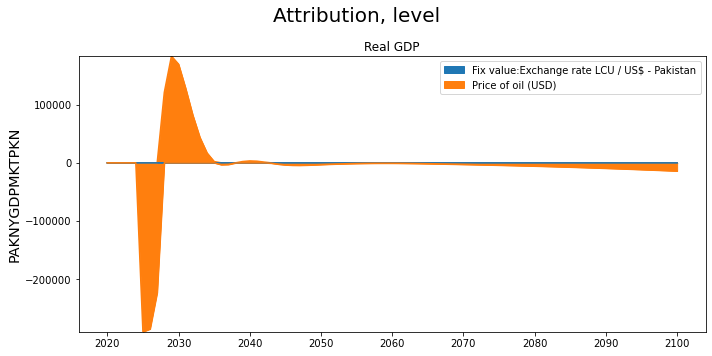

In [59]:
totdekomp = mpak.totdif() # Calculate the total derivatives of all equations in the model.
showvar = 'PAKNYGDPMKTPKN'
totdekomp.explain_all(showvar,kind='area',stacked=True,top=0.20);    

### .explain_all will visualize the results

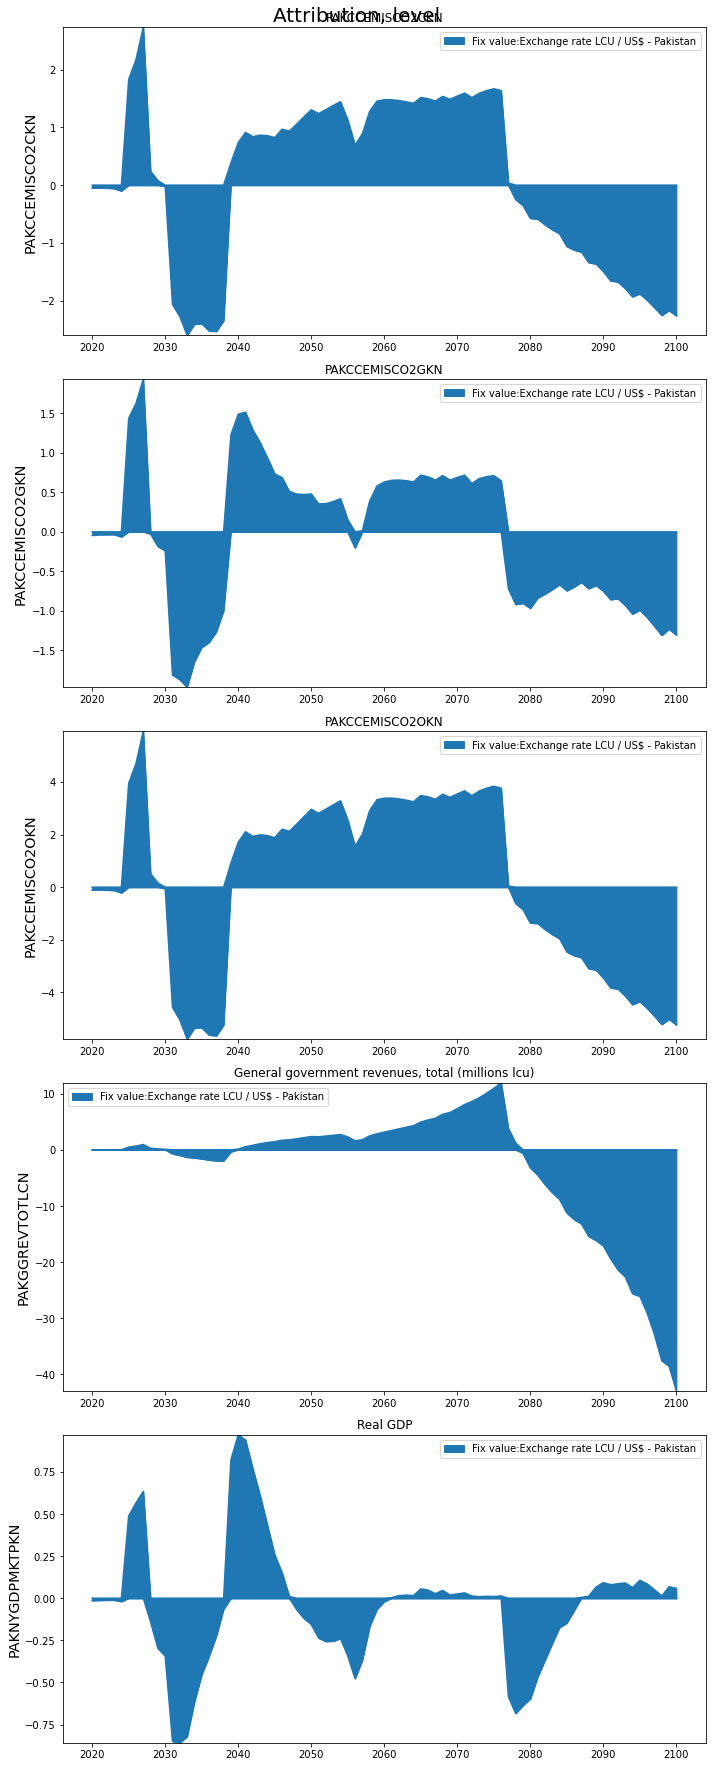

In [42]:
showvar = 'PAKNYGDPMKTPKN PAKCCEMISCO2CKN PAKCCEMISCO2OKN PAKCCEMISCO2GKN PAKGGREVTOTLCN'
totdekomp.explain_all(showvar,kind='area',stacked=True,top=0.95);    


### Or we can use interactive widgets
This allows the user to select the specific variable of interest and what to display: 


:::{note}
If this is read in a manual the widget is not live. 

In a notebook the selection widgets are live. 
:::


In [5]:
display(mpak.get_att_gui(var='PAKGGREVTOTLCN',ysize=7));

interactive(children=(Dropdown(description='Variable', index=108, options=('CHNEXR05', 'CHNPCEXN05', 'DEUEXR05…

None

When the results are displayed, they can be filtered, sliced and diced in a number of ways. 

### More advanced model attribution

For some  models (like the EBA bank stress test model) the number of changed exogenous variables can be large. Using a dictionary to contain the experiments allows us to create experiments where all variables for each country are analyzed, or each macro variable for all countries are analyzed. 

Also it is possible to use aggregated sums - useful for looking at impact on PD's. Or just the last time period - useful for looking at CET1 ratios. 

If there are many experiments, data can be filtered in order to look only at the variables with an impact above a certain threshold. 

The is also the possibility to   anonymize  the row and column names and to randomize
the order of rows and/or columns - useful for bank names. 

### Single equation attribution chart 
The results can be visualized in different ways. 

In [7]:
help(mpak.dekomp_plot)

Help on method dekomp_plot in module modelclass:

dekomp_plot(varnavn, sort=True, pct=True, per='', top=0.9, threshold=0.0, lag=True, rename=True, nametrans=<function Dekomp_Mixin.<lambda> at 0x000002093C157280>, time_att=False) method of modelclass.model instance
    Returns  a chart with attribution for a variable over the smpl  
    
    Parameters
    ----------
    varnavn : TYPE
        variable name.
    sort : TYPE, optional
        . The default is False.
    pct : TYPE, optional
        display pct contribution . The default is True.
    per : TYPE, optional
        DESCRIPTION. The default is ''.
    threshold : TYPE, optional
        cutoff. The default is 0.0.
    rename : TYPE, optional
        Use descriptions instead of variable names. The default is True.
    time_att : TYPE, optional
        Do time attribution . The default is False.
    lag : TYPE, optional
       separete by lags The default is True.           
    top : TYPE, optional
      where to place the titl

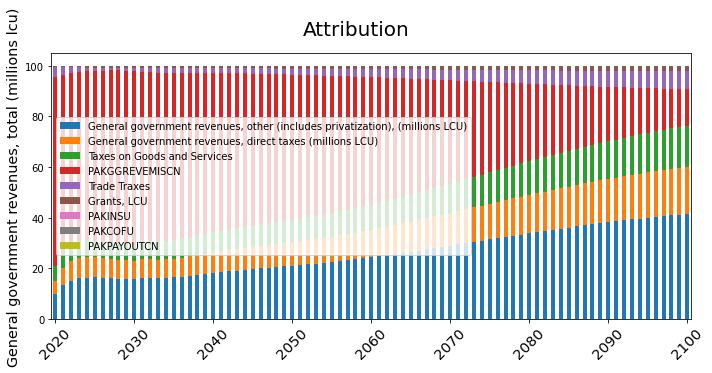

In [8]:
fig=mpak.dekomp_plot('PAKGGREVTOTLCN',pct=1);


### Chart in pct of the total 

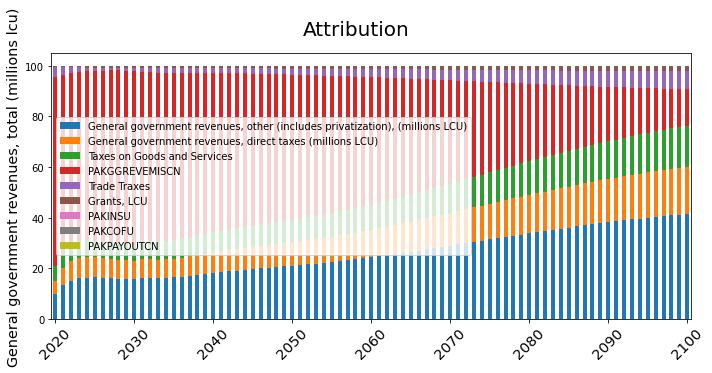

In [9]:
mpak.dekomp_plot('PAKGGREVTOTLCN',rename=1);

### Chart for one year 
The attribution for one year can be dispalyed in a waterfall chart. 

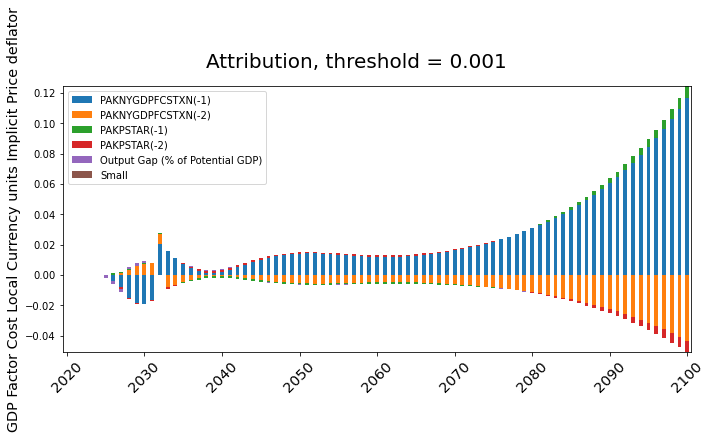

In [67]:
#mpak.dekomp_plot_per('PAKNYGDPMKTPXN',per=2040,rename=1,pct=0,ysize=12,threshold =20);
mpak.dekomp_plot('PAKNYGDPFCSTXN',per=2040,rename=1,pct=0,threshold =0.001);

### Sorting of attribution

C:\Users\wb268970\.conda\envs\modelflow\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


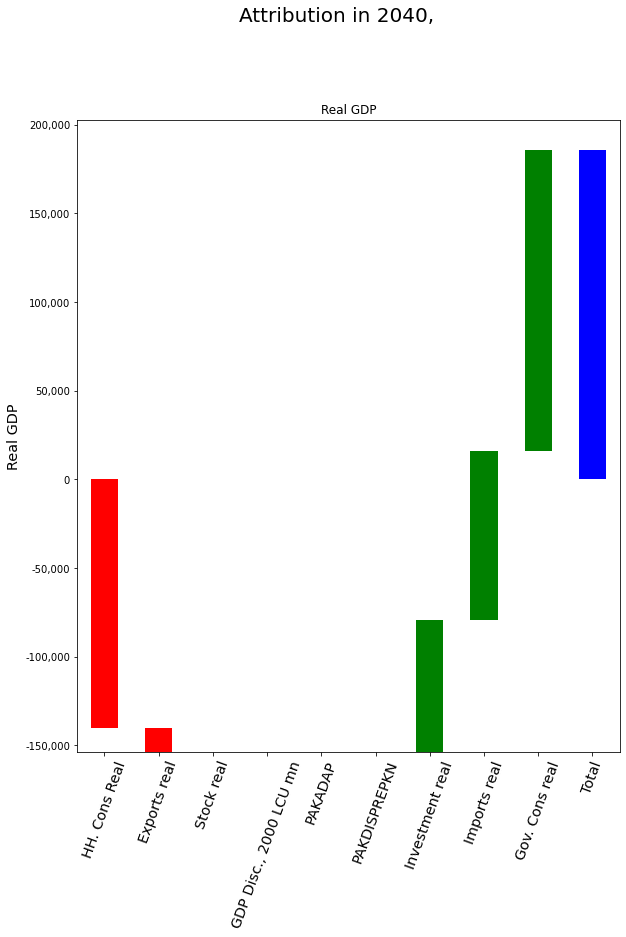

In [11]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,ysize=12);

### Truncate attribution
Some equations have a lot of small contributions. These can be aggregated through the ```threshold=<some number>``` parameter. 
Variables for which all contributions are below the threshold will be lumped together in the **small** bin. Like below:

C:\Users\wb268970\.conda\envs\modelflow\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


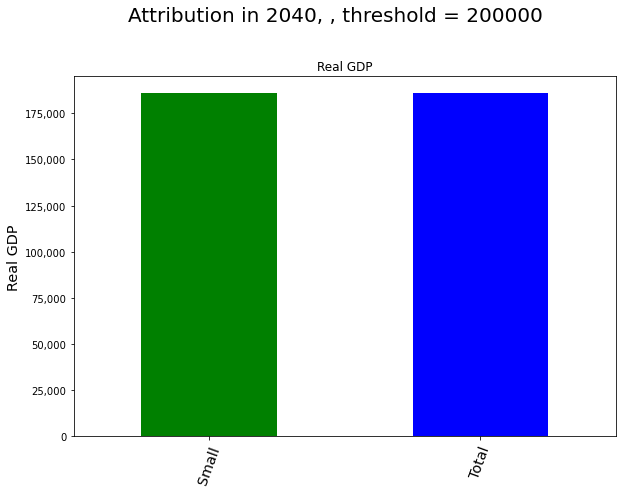

In [12]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,threshold =200000,ysize=7);

### Attribution when comparing time frames 
In this case we seek to find out which variables explains the development from year to year. This is done only for the .lastdf dateframe. 

In [13]:
with mpak.set_smpl(2020,2024):
    mpak['PAKNYGDPMKTPKN'].dekomp(time_att=True)


Formula        : FRML <IDENT> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $ 

                      2020        2021        2022        2023        2024
Variable   lag                                                            
t-1        0   25760579.27 26470022.65 26764926.87 26889649.52 27089036.50
t          0   26470022.65 26764926.87 26889649.52 27089036.50 27454422.35
Difference 0     709443.38   294904.22   124722.65   199386.98   365385.85
Percent    0          2.75        1.11        0.47        0.74        1.35

 Contributions to differende for  PAKNYGDPMKTPKN
                         2020       2021       2022       2023       2024
Variable       lag                                                       
PAKNECONPRVTKN 0    421908.71  220215.41  108899.48  183642.23  333465.16
PAKNECONGOVTKN 0    344368.08   56568.07   -7860.16   16274.44   61873.41
PAKNEGDIFTOTKN 0    222358

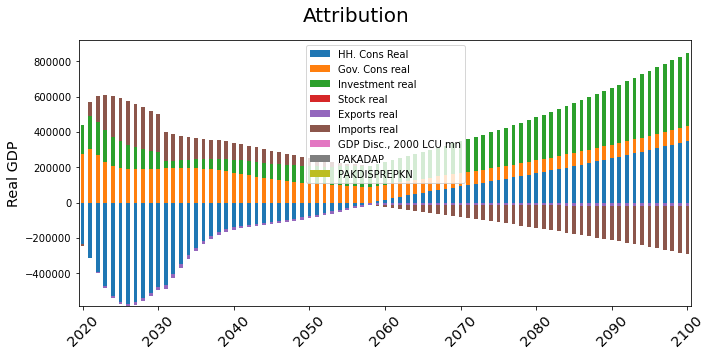

In [14]:
mpak.dekomp_plot('PAKNYGDPMKTPKN',pct=0,rename=1,sort=1,threshold =0,time_att = True);

### Visualizing attribution in dependency graphs
The logical graph of the model can be used to show the upstream and downstream variable for a specific variable. More on this [here](../structure/Logical_structure.ipynb)<br>
When drawing the logical graph for a variable the model attribution will be used to guide the thickness of edges between nodes (variables). This enables a visual impression of which 
variables drives the impact. 

::: {note}
If png == 0 the graph below will be rendered in SVG format. This enables tooltips with additional information when the mouse hovers 
over an edge or an node. 

Unfortunately svg can't be displayed in the manual, so png has to be True for the manual. In a live jupyter notebook set latex=0. This will 
enable svg format. 
:::

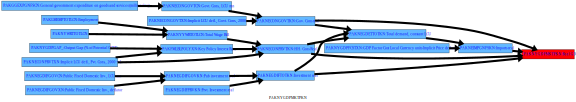

In [84]:
#mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=3,down=0,png=latex,filter=20) # For book
mpak['PAKNYGDPMKTPKN'].draw(up=3,down=0,png=False,filter=400,svg=True,size=(8,40))#3 for interactice

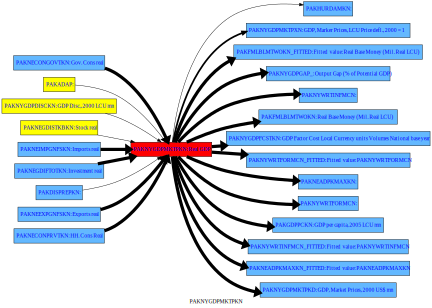

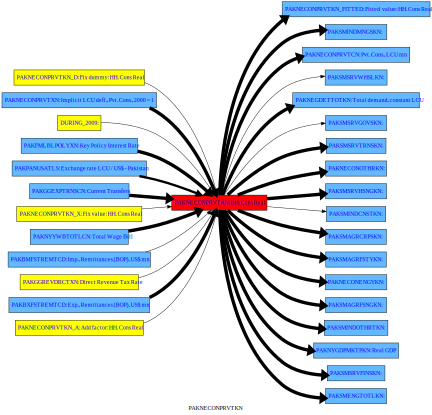

In [15]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1,png=latex)  # diagram all direct dependencies 

### The attribution can be filtered and more levels can be displayed. 

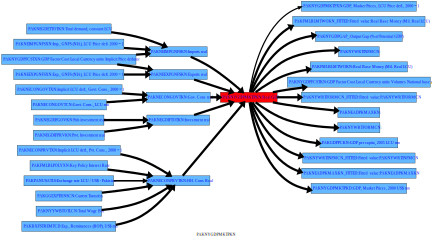

In [16]:
mpak['PAKNYGDPMKTPKN'].draw(up=2,down=1,png=latex,filter=20) 

### Or it can be used in a dashboard (not avaiable in the offline manual) 

In [68]:

try:
    mpak.modeldash('PAKNYGDPMKTPKN',jupyter=1,inline=False)
except: 
    print('No Dashboard installed')

No Dash
No Dash, name 'DashInteractiveGraphviz' is not defined


In [ ]:
!pip install 